### Import python modules 

In [18]:
# 导入模块
import os
os.environ['CUDA_VISIBLE_DEVICES']= '0'

import math
import random
import numpy as np
import apply
import json
from pprint import pprint
import torch
import torch.nn.functional as F

import models, utils, draw, dataset

random_state = 12314
torch.manual_seed(random_state) # cpu
np.random.seed(random_state)    # numpy
random.seed(random_state)       # random and transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    num_GPU = torch.cuda.device_count()
    print(f"可用 GPU 数量: {num_GPU}")
else:
    num_GPU = 1
    
print(f"运行平台: {device}")
root_path = os.path.abspath('.')

figsize = (4,4)

可用 GPU 数量: 1
运行平台: cuda


### Load synthetic geologic models

In [19]:
dataset_name = "seismic_facies_f3-segmentation-6118"
dataset_path = os.path.join("dataset", dataset_name)

samples_train = dataset.read_json(os.path.join(dataset_path, 'samples_train.json'))
samples_valid = dataset.read_json(os.path.join(dataset_path, 'samples_valid.json'))

print(f"训练样本数量: {len(samples_train)}")
print(f"验证样本数量: {len(samples_valid)}")

data_info = dataset.read_json(os.path.join(dataset_path, 'summary.json'))
classes = data_info['classes']
palette = np.array(data_info['palette'])
image_type = data_info.get('image_type', ['data'])
num_classes = len(classes)
print(f"类别总数: {num_classes}")

训练样本数量: 162
验证样本数量: 17
类别总数: 5


In [20]:
param = dict()

# 数据参数
param['classes'] = classes
param['image_type'] = image_type
param['task_mode'] = 'segment'

# 网络种类
param['model_name'] = "SDSAM"
param['sam_checkpoint'] = True
param['model_type'] = "vit_b"
param['transfer'] = "lora"
param['num_lora'] = 1
param['encoder_type'] = 'vit'
param['use_graph'] = False

# 提示引擎
param['iterations'] = 1
param['mask_threshold'] = 0.0
param['prompt_types'] = []

# 网络架构
param['mask_in_chans'] = 64
param['image_encode_size'] = 512
param['num_multimask_outputs'] = num_classes
param['mask_decoder_depth'] = 4
param['mask_decoder_heads'] = 8
param['mask_mlp_hidden_dim'] = 2048
param['image_encode_dim'] = 512

# 训练参数
param['epochs'] = 100    # 训练轮数
param['batch_size'] = num_GPU * 16 # 批大小
param['warmup_steps'] = 0
param['num_GPU'] = num_GPU
param['disp_inter'] = 10 # 显示间隔
param['save_inter'] = 10 # 保存间隔
param['test_inter'] = 10

# 学习参数
param['lr'] = 1e-4         # 学习率
param['optimizer_type'] = 'AdamW' # 优化器类型
param['weight_decay'] = 0.0 # 权重衰减
param['gamma'] = 0.5    # 学习率衰减系数
param['lr_decay'] = 10   # 学习率衰减周期
param['decay_type'] = 'ReduceLROnPlateau'

# 损失函数
param['loss_type'] = {'focal': 20.0, 'dice': 1.0}

In [21]:
train_data =  utils.build_dataset_facies(param, samples_train, mode='Train', norm='mea_std')

train_sample: dict_keys(['image', 'UID', 'original_size', 'masks', 'labels'])


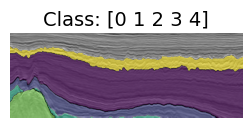

In [22]:
train_sample = train_data[12]
print(f"train_sample: {train_sample.keys()}")
image = train_sample['image'][0]
masks = train_sample['masks'][0]
labels = train_sample['labels'][0]

draw.draw_img(image, msk=masks, figsize=(3,3), 
              text=f"Class: {labels}", 
              maskcolor=[palette[i-1] for i in labels], origin='upper')

show_each_class = False
if show_each_class:
    for k in range(masks.shape[0]):
        draw.draw_img(image, origin='upper',
                      cmap='gray',
                      msk=[masks[k]], 
                      text=f"Class[{k}]: {labels[k]}",
                      maskcolor=[palette[labels[k]]],
                      figsize=(3,3))

### Training CNN

In [23]:
train_data =  utils.build_dataset_facies(param, samples_train, mode='Train', norm='mea_std')
valid_data =  utils.build_dataset_facies(param, samples_valid, mode='Valid', norm='mea_std')

In [24]:
# 定义网络
model = getattr(models, param['model_name'])(param)
loss_name = '+'.join([f"{'{:.3f}'.format(value)}*{key}" for key, value in param['loss_type'].items()])    

Loading Checkpoint: segment_anything/checkpoints/sam_vit_b_01ec64.pth ...


In [25]:
# 并行模式
if num_GPU > 1:
    print(f"多核模式")
    model = torch.nn.DataParallel(model, device_ids=range(num_GPU)).to(device)
else:
    print(f"单核模式")  
model = model.to(device)

单核模式


In [26]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
num_params = count_trainable_parameters(model)
print(f"Trainable parameters: {num_params:,}")

Trainable parameters: 88,678,715


In [30]:
# 模型保存路径   
if param['model_name'] in ['SDSAM']:
    task_name = param['encoder_type']
    model_name = '-'.join([param['model_name'], param['model_type']])
else:
    model_name = param['model_name']
    task_name = model_name
    
task_name = param['encoder_type']
if param['encoder_type'] == 'vit':
    task_name = '_'.join([task_name, param['transfer']])
    if param['transfer'] == "lora":
        task_name = task_name + str(param['num_lora'])

session_name = '-'.join([
    model_name, 
    "dataset_"+dataset_name, 
    task_name.lower(),
])                                     
            
checkpoint_path = os.path.join('result', session_name)
param['checkpoint_path'] = checkpoint_path    
param['use_checkpoint'] = True
print(f"模型读取路径: {checkpoint_path}")

模型读取路径: result/SDSAM-vit_b-dataset_seismic_facies_f3-segmentation-6118-vit_lora1


In [ ]:
# 训练网络
utils.train_valid_net(param, model, train_data, valid_data=valid_data, device=device)

### Inference

In [32]:
# 载入模型
checkpoint_file = [x for x in os.listdir(checkpoint_path) if x.endswith('checkpoint-best.pth')][0]
model.load_state_dict(torch.load(os.path.join(checkpoint_path, checkpoint_file))['state_dict'])

<All keys matched successfully>

In [33]:
samples_valid = dataset.read_json(os.path.join(dataset_path, 'samples_valid.json'))
valid_data =  utils.build_dataset_facies(param, samples_valid, mode='Valid', norm='mea_std')

In [35]:
apply_func = apply.Valid(param, model, device='cuda')
collect_outputs = apply_func.apply(valid_data, 0.5)

collect_output0: dict_keys(['image', 'UID', 'original_size', 'masks', 'labels', 'pred_probs', 'pred_masks'])
key[image]: (1, 255, 700)
key[UID]: (1,)
key[original_size]: (2,)
key[masks]: (5, 255, 700)
key[labels]: (1, 5)
key[pred_probs]: (5, 255, 700)
key[pred_masks]: (5, 255, 700)


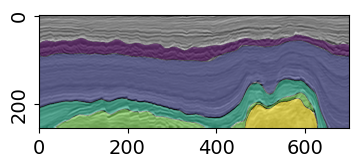

In [36]:
k = 14

collect_output0 = collect_outputs[k]
print(f"collect_output0: {collect_output0.keys()}")
for key in collect_output0:
    print(f"key[{key}]: {collect_output0[key].shape}")
image = collect_output0['image'][0]
masks = collect_output0['masks']
labels = collect_output0['labels'][0]
pred_probs0 = collect_output0['pred_probs'] 
pred_masks0 = collect_output0['pred_masks']

pred_masks0 = apply.postprocess_mask(pred_masks0, 600)

figsize = (4,4)
draw.draw_img(image, msk=pred_masks0, figsize=figsize, origin='upper',
         maskcolor=[palette[i] for i in labels],
         axis_off=False)

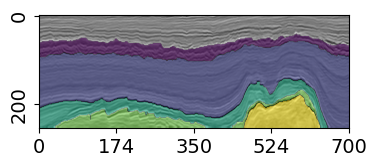

In [37]:
draw.draw_img(image, msk=masks, figsize=figsize, origin='upper',
         maskcolor=[palette[i] for i in labels], xtick_num=5,
         axis_off=False)

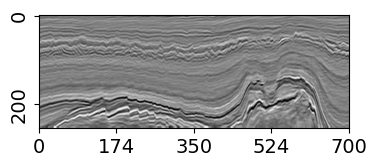

In [38]:
draw.draw_img(image, figsize=figsize, origin='upper', cmap='gray',
              xtick_num=5, axis_off=False)

In [39]:
segment_metrics = apply.SegmentationMetrics()
num_sample = len(collect_outputs)
metrics_avg = dict()
for j in range(num_sample):
    collect_output0 = collect_outputs[j]
    masks = collect_output0['masks']
    pred_masks0 = collect_output0['pred_masks']
    metrics = segment_metrics(pred_masks0, masks)
    if j == 0:
        for key in metrics.keys(): 
            metrics_avg[key] = metrics[key] / num_sample
    else:
        for key in metrics.keys(): 
            metrics_avg[key] += metrics[key] / num_sample
            
pprint(metrics_avg)

{'acc': tensor(0.9921),
 'ap': tensor(0.8890),
 'ck': tensor(0.9208),
 'f1': tensor(0.9262),
 'jacc': tensor(0.8859),
 'macc': tensor(0.9260),
 'recall': tensor(0.9245)}
